In [1]:
#notebook to analyze the Sag River Discharge fits
#by Mike, January 29, 2021
# rui modified, June 2021 for discharge parameters calibration

In [2]:
# 1) add FLaPE-Byrd repository location (pulled from github.com/mikedurand/flape-byrd) to the path
import sys
sys.path.append('/Users/rui/OneDrive - The Ohio State University/SWOT_discharge/test_Q_algo/sac/FLaPE-Byrd/') 

In [3]:
# 2) import needed modules
from FlowLawCalibration import FlowLawCalibration
from pprint import pprint
from FlowLaws import MWACN,MWAPN,HiVDI,MOMMA
import scipy.io
import numpy as np

In [4]:
river_data = scipy.io.loadmat('/Users/rui/OneDrive - The Ohio State University' \
                              '/SWOT_discharge/test_Q_algo/sac/rch_data.mat')

In [5]:
class Domian:
    def __init__(self, river_data):
        self.nR=len(river_data['rch_id_uniq']) #number of reaches
        self.nt=25 #number of overpasses
        self.t=np.array(range(25))

D = Domian(river_data)

In [6]:
class ReachTruth:
    def __init__(self, river_data):
        self.A0 = river_data['rch_ave']['Abar'][0,0].T
        self.Q = river_data['rch_ave']['q'][0,0]
        self.S = river_data['rch_gdem']['slp'][0,0]
        self.w = river_data['rch_gdem']['width'][0,0]
        self.h = river_data['rch_gdem']['wse'][0,0]
        

Truth = ReachTruth(river_data)

In [7]:
class ReachObs:
    def __init__(self, river_data):
        self.h = river_data['rch_swot']['wse'][0,0]
        self.h0 = self.h[:,18].T
        self.S = river_data['rch_swot']['slp'][0,0]
        self.w = river_data['rch_swot']['width'][0,0]
        self.dA = river_data['rch_ave']['dA'][0,0]


Obs = ReachObs(river_data)

In [8]:
# 6) For each reach (usually just one for ArcticDEM) and for each flow law variant, do the calibration calculations
Variants=['Constant-n', 'PowerLaw-n', 'HiVDI', 'MOMMA']

ReachData=[]
for r in range(0,D.nR):
    ReachDict={}
    ReachDict['dA']=Obs.dA[r,:]
    ReachDict['w']=Obs.w[r,:]
    ReachDict['S']=Obs.S[r,:]
    ReachDict['h']=Obs.h[r,:]
    ReachDict['Qtrue']=Truth.Q[r,:]
    ReachDict['Strue']=Truth.S[r,:]
    
    ReachData.append(ReachDict)

cals=[] #make a list of results, indexed by reach #
for r in range(0,D.nR):    
    FlowLawVariants={} #stash flow law variant objects for each reach in a dict       
    if 'Constant-n' in Variants and len(ReachData[r]['dA'][~np.isnan(ReachData[r]['w'])]) != 0:     
        FlowLawVariants['BAMSADS']=MWACN(ReachData[r]['dA'][~np.isnan(ReachData[r]['w'])],
                                         ReachData[r]['w'][~np.isnan(ReachData[r]['w'])],
                                         ReachData[r]['S'][~np.isnan(ReachData[r]['w'])],
                                         ReachData[r]['h'][~np.isnan(ReachData[r]['w'])])        
        
    if 'PowerLaw-n' in Variants and len(ReachData[r]['dA'][~np.isnan(ReachData[r]['w'])]) != 0:
        FlowLawVariants['MetroMan']=MWAPN(ReachData[r]['dA'][~np.isnan(ReachData[r]['w'])],
                                          ReachData[r]['w'][~np.isnan(ReachData[r]['w'])],
                                          ReachData[r]['S'][~np.isnan(ReachData[r]['w'])],
                                          ReachData[r]['h'][~np.isnan(ReachData[r]['w'])])      
    
    if 'HiVDI' in Variants and len(ReachData[r]['dA'][~np.isnan(ReachData[r]['w'])]) != 0:
        FlowLawVariants['HiVDI']=HiVDI(ReachData[r]['dA'][~np.isnan(ReachData[r]['w'])],
                                       ReachData[r]['w'][~np.isnan(ReachData[r]['w'])],
                                       ReachData[r]['S'][~np.isnan(ReachData[r]['w'])],
                                       ReachData[r]['h'][~np.isnan(ReachData[r]['w'])])  
        
    if 'MOMMA' in Variants and len(ReachData[r]['dA'][~np.isnan(ReachData[r]['w'])]) != 0:
        FlowLawVariants['MOMMA']=MOMMA(ReachData[r]['dA'][~np.isnan(ReachData[r]['w'])],
                                       ReachData[r]['w'][~np.isnan(ReachData[r]['w'])],
                                       ReachData[r]['S'][~np.isnan(ReachData[r]['w'])],
                                       ReachData[r]['h'][~np.isnan(ReachData[r]['w'])]) 
            
    cal={} #make a dictionary of results, keyed off the flow law variant name
    for variant in FlowLawVariants.keys():  
        flow_law_cal=FlowLawCalibration(D,ReachData[r]['Qtrue'][~np.isnan(ReachData[r]['w'])],
                                        FlowLawVariants[variant])
        flow_law_cal.CalibrateReach()
        cal[variant]=flow_law_cal

    cals.append(cal)

/Users/rui/Desktop/Git/FLaPE-Byrd/FlowLaws.py:81: RuntimeWarning: divide by zero encountered in true_divide
  Q=1/n*((self.h - params[0])*(1/3))**(5/3)*self.W*self.S**(1/2)
/Users/rui/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/rui/Desktop/Git/FLaPE-Byrd/FlowLaws.py:28: RuntimeWarning: invalid value encountered in sqrt
  Q=1/params[0]*(params[1]+self.dA)**(5/3)*self.W**(-2/3)*self.S**(1/2)
/Users/rui/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
/Users/rui/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
/Users/rui/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x

In [9]:
# MetroMan params: 1. ninf; 2. Abar; 3. p
# BAM and SADS params: 1. n; 2. Abar
# HiVDI params: 1. alpha; 2. Abar; 3. beta

MetroMan_params = []
BAMSADS_params = []
HiVDI_params = []
MOMMA_params = []
for i in range(4,18):
    #if cals[i]['PowerLaw-n'].param_est is not None:
        #MetroMan_params = MetroMan_params.append(cals[i]['PowerLaw-n'].param_est)
        MetroMan_params.append(cals[i]['MetroMan'].param_est)
        BAMSADS_params.append(cals[i]['BAMSADS'].param_est)
        HiVDI_params.append(cals[i]['HiVDI'].param_est)
        MOMMA_params.append(cals[i]['MOMMA'].param_est)

metroman = {"MetroMan_params": np.array(MetroMan_params) }
bamsads = {"BAMSADS_params": np.array(BAMSADS_params) }
hivdi = {"HiVDI_params": np.array(HiVDI_params) }
momma = {"MOMMA_params": np.array(MOMMA_params) }

MOMMA reach 1


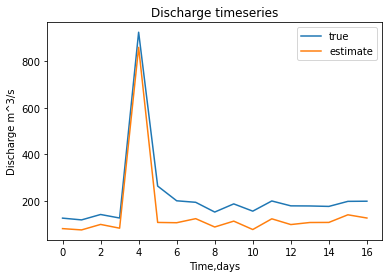

MetroMan/HiVDI reach 1


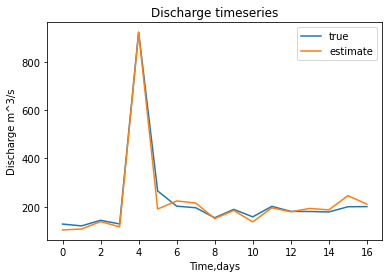

BAM/SADS reach 1


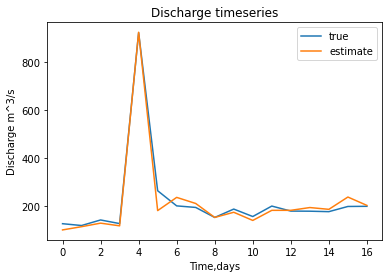

MOMMA reach 2


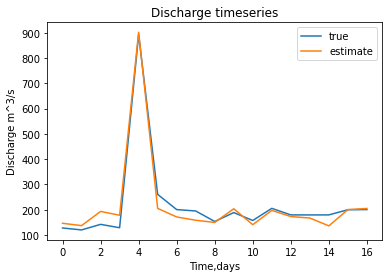

MetroMan/HiVDI reach 2


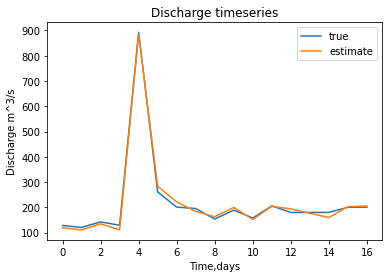

BAM/SADS reach 2


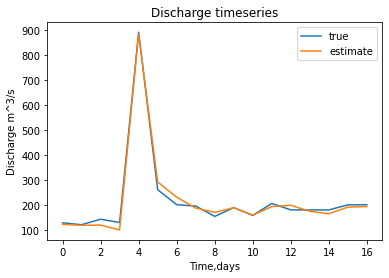

MOMMA reach 3


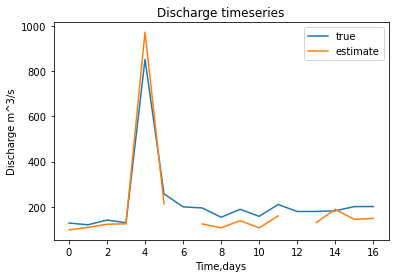

MetroMan/HiVDI reach 3


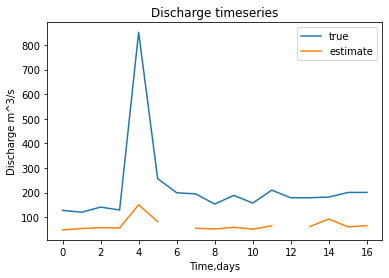

BAM/SADS reach 3


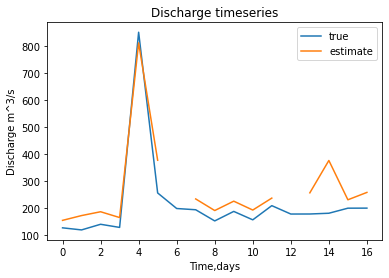

MOMMA reach 4


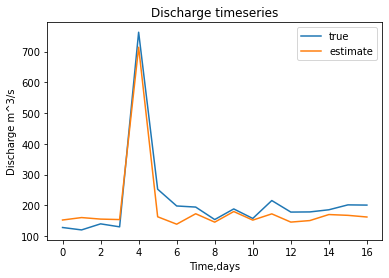

MetroMan/HiVDI reach 4


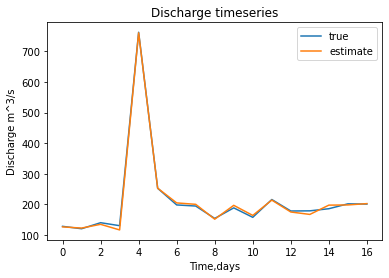

BAM/SADS reach 4


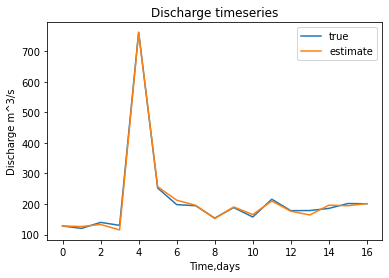

MOMMA reach 5


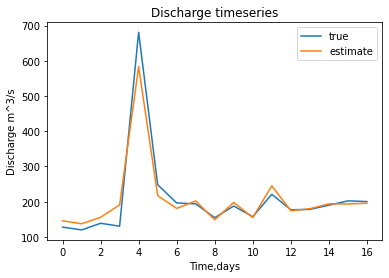

MetroMan/HiVDI reach 5


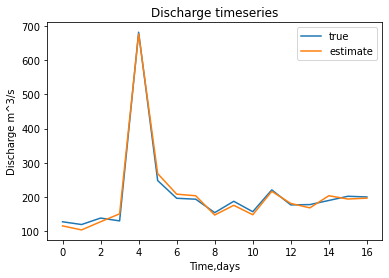

BAM/SADS reach 5


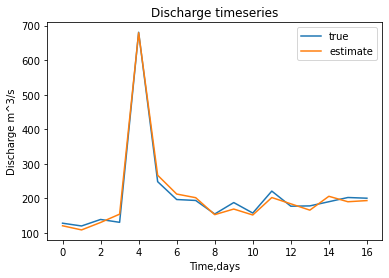

MOMMA reach 6


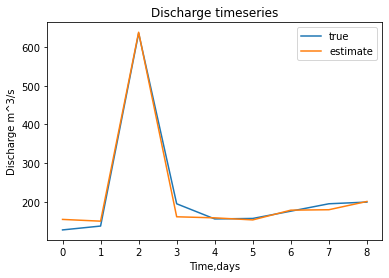

MetroMan/HiVDI reach 6


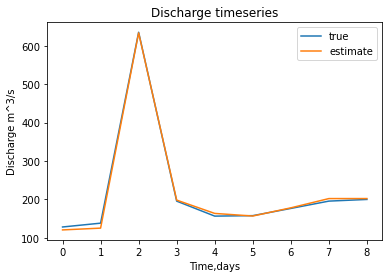

BAM/SADS reach 6


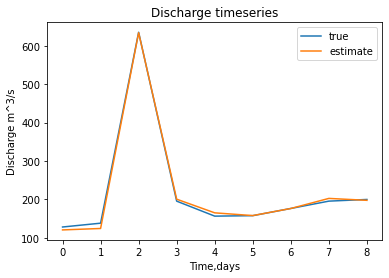

MOMMA reach 7


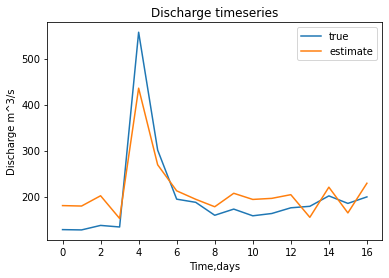

MetroMan/HiVDI reach 7


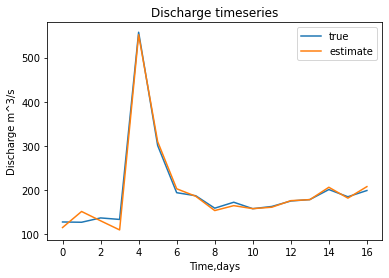

BAM/SADS reach 7


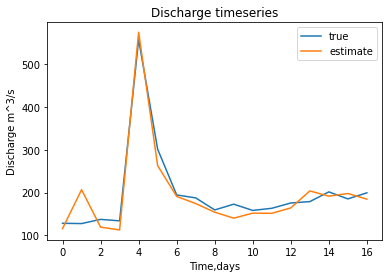

MOMMA reach 8


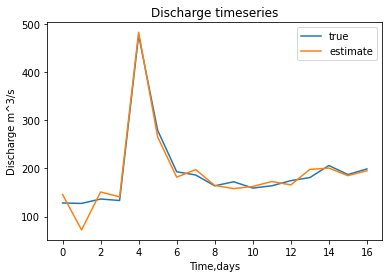

MetroMan/HiVDI reach 8


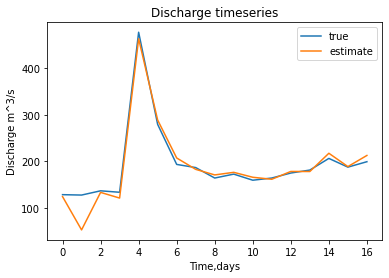

BAM/SADS reach 8


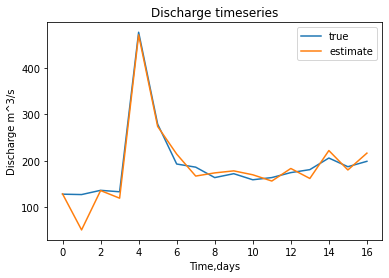

MOMMA reach 9


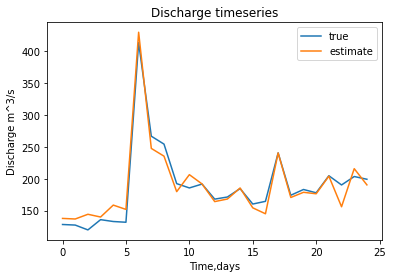

MetroMan/HiVDI reach 9


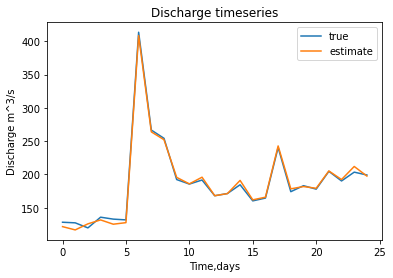

BAM/SADS reach 9


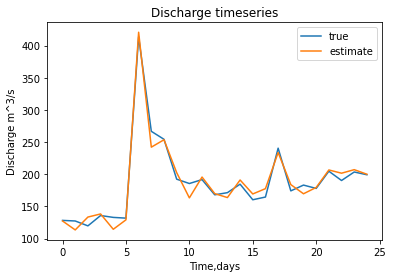

MOMMA reach 10


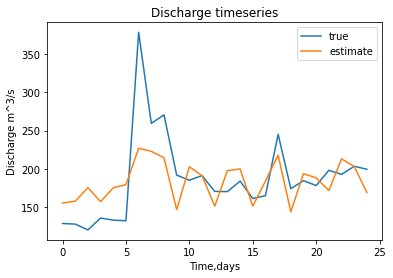

MetroMan/HiVDI reach 10


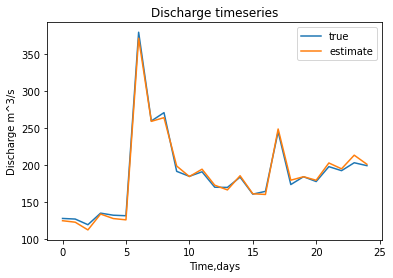

BAM/SADS reach 10


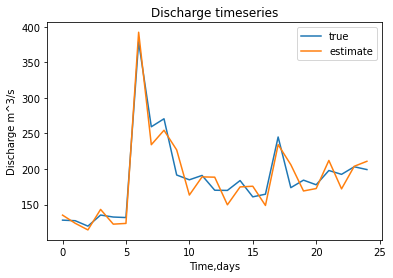

MOMMA reach 11


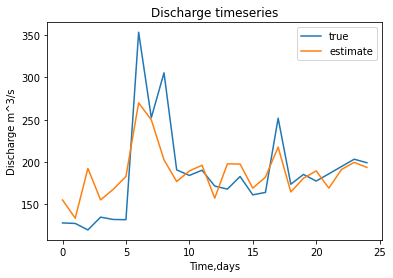

MetroMan/HiVDI reach 11


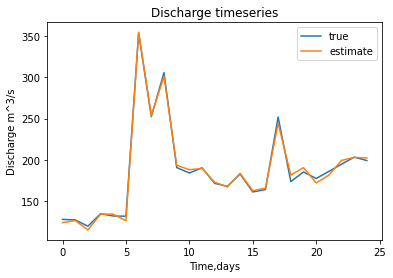

BAM/SADS reach 11


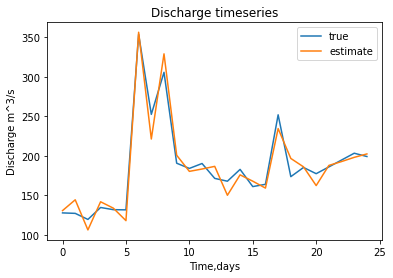

MOMMA reach 12


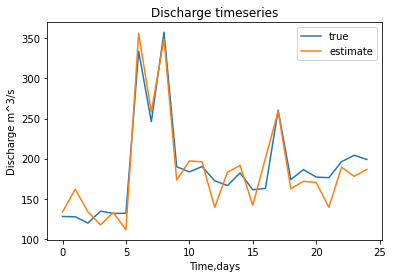

MetroMan/HiVDI reach 12


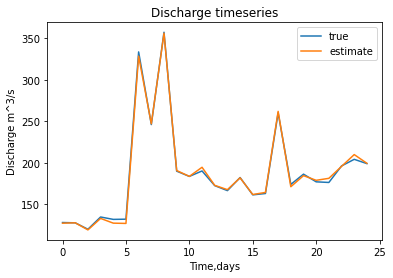

BAM/SADS reach 12


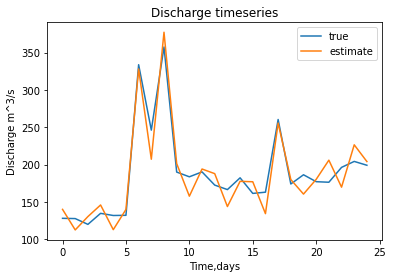

MOMMA reach 13


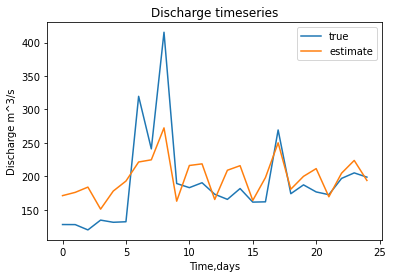

MetroMan/HiVDI reach 13


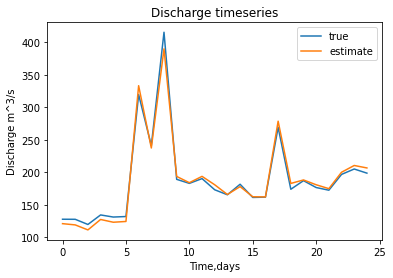

BAM/SADS reach 13


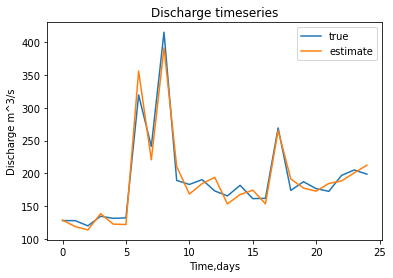

In [22]:
for i in range(4,17):
    print('MOMMA reach', i-3)
    cals[i]['MOMMA'].PlotTimeseries2()
    print('MetroMan/HiVDI reach', i-3)
    cals[i]['MetroMan'].PlotTimeseries2()
    print('BAM/SADS reach', i-3)
    cals[i]['BAMSADS'].PlotTimeseries2()

In [10]:
momma

{'MOMMA_params': array([[1.44529980e+00, 1.21679497e+01, 7.22649902e-05],
        [1.67938563e-02, 1.00251922e+01, 3.04037264e-04],
        [2.00000000e+00, 1.30000000e+01, 1.00000000e-04],
        [1.99989747e+00, 1.29999735e+01, 1.75057248e-03],
        [2.43023632e+00, 1.29587184e+01, 2.30614884e-04],
        [5.04093504e+00, 1.26683788e+01, 2.60914511e-04],
        [4.16064158e+00, 1.26616737e+01, 5.08559955e-02],
        [1.02445120e+01, 1.35293137e+01, 8.04971276e-03],
        [1.33571386e+01, 1.47238269e+01, 2.99297462e+00],
        [1.31295265e+01, 1.88153001e+01, 5.50596508e+00],
        [1.46814317e+01, 2.16923466e+01, 6.67166857e+00],
        [2.47481010e+01, 2.55098968e+01, 1.31817670e+00],
        [2.38952008e+01, 2.66900378e+01, 1.04066539e+01],
        [2.72474911e+01, 3.05386055e+01, 1.20188604e+01]])}

In [11]:
metroman

{'MetroMan_params': array([[9.53877384e-03, 1.58802705e+02, 5.95505871e-01],
        [1.03922195e-02, 1.68324002e+02, 5.24674940e-01],
        [3.00000000e-02, 3.50000000e+02, 1.00000000e+00],
        [1.28693538e-02, 2.01834401e+02, 3.61862955e-01],
        [1.30238994e-02, 1.95370447e+02, 3.65271153e-01],
        [1.59208754e-02, 1.96157776e+02, 2.60828667e-01],
        [1.00742924e-02, 1.38117273e+02, 7.91454139e-01],
        [1.49615513e-02, 1.78901191e+02, 4.85360485e-01],
        [1.80122517e-02, 1.75535716e+02, 5.81732359e-01],
        [1.55872415e-02, 1.63607798e+02, 6.01471497e-01],
        [1.63078245e-02, 1.72213132e+02, 6.55894425e-01],
        [1.75813549e-02, 1.53878240e+02, 6.09776704e-01],
        [1.29662043e-02, 1.35286628e+02, 5.15082194e-01],
        [1.70310670e-02, 1.58393421e+02, 5.21339693e-01]])}

In [12]:
# save to .mat 
# scipy.io.savemat('MetroMan_params_v2_nan.mat', metroman)
# scipy.io.savemat('BAMSADS_params_v2_nan.mat', bamsads)
# scipy.io.savemat('HiVDI_params_v2_nan.mat', hivdi)
scipy.io.savemat('MOMMA_params_v3_nan.mat', momma)

In [26]:
bamsads

{'BAMSADS_params': array([[3.08860073e-02, 2.47400318e+02],
        [3.02843548e-02, 2.51290612e+02],
        [3.00000000e-02, 3.50000000e+02],
        [2.26297700e-02, 2.51499132e+02],
        [2.84606342e-02, 2.61218054e+02],
        [2.55850125e-02, 2.32530197e+02],
        [3.74143155e-02, 2.76554649e+02],
        [2.85019995e-02, 2.43147044e+02],
        [3.41053506e-02, 2.65814940e+02],
        [2.99924560e-02, 2.69875942e+02],
        [3.51353873e-02, 2.73689265e+02],
        [3.67803429e-02, 2.62538048e+02],
        [2.18159306e-02, 2.01791156e+02],
        [2.88777516e-02, 2.30118408e+02]])}

In [27]:
hivdi

{'HiVDI_params': array([[ 1.04805706e+02,  1.58828162e+02, -5.95357487e-01],
        [ 9.62023453e+01,  1.68345838e+02, -5.24550811e-01],
        [ 3.33333333e+01,  3.50000000e+02, -1.00000000e+00],
        [ 7.76794587e+01,  2.01865566e+02, -3.61657236e-01],
        [ 7.67647956e+01,  1.95390430e+02, -3.65162731e-01],
        [ 6.27962546e+01,  1.96176902e+02, -2.60697159e-01],
        [ 9.92594017e+01,  1.38121619e+02, -7.91433727e-01],
        [ 6.68355199e+01,  1.78905964e+02, -4.85335992e-01],
        [ 5.55163348e+01,  1.75540265e+02, -5.81707540e-01],
        [ 6.41539604e+01,  1.63611088e+02, -6.01457116e-01],
        [ 2.33921089e+01,  3.33407853e+02, -1.31666753e-01],
        [ 5.68781341e+01,  1.53879358e+02, -6.09770407e-01],
        [ 7.71225536e+01,  1.35288544e+02, -5.15070284e-01],
        [ 5.87151012e+01,  1.58396438e+02, -5.21321895e-01]])}

In [28]:
metroman

{'MetroMan_params': array([[9.53877384e-03, 1.58802705e+02, 5.95505871e-01],
        [1.03922195e-02, 1.68324002e+02, 5.24674940e-01],
        [3.00000000e-02, 3.50000000e+02, 1.00000000e+00],
        [1.28693538e-02, 2.01834401e+02, 3.61862955e-01],
        [1.30238994e-02, 1.95370447e+02, 3.65271153e-01],
        [1.59208754e-02, 1.96157776e+02, 2.60828667e-01],
        [1.00742924e-02, 1.38117273e+02, 7.91454139e-01],
        [1.49615513e-02, 1.78901191e+02, 4.85360485e-01],
        [1.80122517e-02, 1.75535716e+02, 5.81732359e-01],
        [1.55872415e-02, 1.63607798e+02, 6.01471497e-01],
        [1.63078245e-02, 1.72213132e+02, 6.55894425e-01],
        [1.75813549e-02, 1.53878240e+02, 6.09776704e-01],
        [1.29662043e-02, 1.35286628e+02, 5.15082194e-01],
        [1.70310670e-02, 1.58393421e+02, 5.21339693e-01]])}

In [12]:
hivdi

{'HiVDI_params': array([[ 1.04805706e+02,  1.58828162e+02, -5.95357487e-01],
        [ 9.62023453e+01,  1.68345838e+02, -5.24550811e-01],
        [ 3.33333333e+01,  3.50000000e+02, -1.00000000e+00],
        [ 7.76794587e+01,  2.01865566e+02, -3.61657236e-01],
        [ 7.67647956e+01,  1.95390430e+02, -3.65162731e-01],
        [ 6.27962546e+01,  1.96176902e+02, -2.60697159e-01],
        [ 9.92594017e+01,  1.38121619e+02, -7.91433727e-01],
        [ 6.68355199e+01,  1.78905964e+02, -4.85335992e-01],
        [ 5.55163348e+01,  1.75540265e+02, -5.81707540e-01],
        [ 6.41539604e+01,  1.63611088e+02, -6.01457116e-01],
        [ 2.33921089e+01,  3.33407853e+02, -1.31666753e-01],
        [ 5.68781341e+01,  1.53879358e+02, -6.09770407e-01],
        [ 7.71225536e+01,  1.35288544e+02, -5.15070284e-01],
        [ 5.87151012e+01,  1.58396438e+02, -5.21321895e-01]])}